# 대회 소개

# Binary Classification with a Bank Churn Dataset
- Playground Series - Season 4, Episode 1

## 모듈가져오기 및 데이터 load

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install -q catboost
!pip install --upgrade -q xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.1 MB/s eta 0:00:00


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
import pkg_resources

# 사용된 모듈과 버전 가져오기
modules = [
    'pandas',
    'matplotlib',
    'numpy',
    'seaborn',
    'scipy',
    'scikit-learn',
    'lightgbm',
    'catboost'
]

module_versions = {}

for module in modules:
    try:
        version = pkg_resources.get_distribution(module).version
    except pkg_resources.DistributionNotFound:
        version = 'Not Found'
    module_versions[module] = version

module_df = pd.DataFrame(module_versions.items(), columns=['Module', 'Version']).set_index('Module')
module_df

,Version
Module,
pandas,2.0.3
matplotlib,3.7.1
numpy,1.25.2
seaborn,0.13.1
scipy,1.11.4
scikit-learn,1.2.2
lightgbm,4.1.0
catboost,1.2.5


In [ ]:
#데이터 추가
sub_data=pd.read_csv('Churn_Modelling.csv')
raw_train=pd.read_csv('train.csv')
raw_test=pd.read_csv('test.csv')
sample_submission=pd.read_csv('sample_submission.csv')

# eda
- 추가데이터의 결측치 날리고 진행

In [ ]:
sub_data.drop("RowNumber", axis=1, inplace=True)
sub_data.dropna(inplace=True)
sub_data.drop_duplicates(keep='first', inplace = True)

In [ ]:
raw_train = pd.concat([raw_train, sub_data], axis=0)

In [ ]:
raw_train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [ ]:
raw_test.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


In [ ]:
display(raw_train.info()),display(raw_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110023 entries, 0 to 110022
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               110023 non-null  int64  
 1   CustomerId       110023 non-null  int64  
 2   Surname          110023 non-null  object 
 3   CreditScore      110023 non-null  int64  
 4   Geography        110023 non-null  object 
 5   Gender           110023 non-null  object 
 6   Age              110023 non-null  float64
 7   Tenure           110023 non-null  int64  
 8   Balance          110023 non-null  float64
 9   NumOfProducts    110023 non-null  int64  
 10  HasCrCard        110023 non-null  float64
 11  IsActiveMember   110023 non-null  float64
 12  EstimatedSalary  110023 non-null  float64
dtypes: float64(5), int64(5), object(3)
memory usage: 10.9+ MB


None

(None, None)

In [ ]:
raw_train['Gender'].nunique(),raw_test['Gender'].nunique()

(2, 2)

In [ ]:
raw_train.describe()

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.0000,1.650340e+05,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,82516.5000,1.569201e+07,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,47641.3565,7.139782e+04,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,0.0000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,41258.2500,1.563314e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,82516.5000,1.569017e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,123774.7500,1.575682e+07,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,165033.0000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


## 고유값, 결측치 확인

In [ ]:
# Creating a table for missing values, unique values and data types of the features

missing_values_train = pd.DataFrame({'Feature': raw_train.columns,
                              '[TRAIN] No. of Missing Values': raw_train.isnull().sum().values,
                              '[TRAIN] % of Missing Values': ((raw_train.isnull().sum().values)/len(raw_train)*100)})

missing_values_test = pd.DataFrame({'Feature': raw_test.columns,
                             '[TEST] No.of Missing Values': raw_test.isnull().sum().values,
                             '[TEST] % of Missing Values': ((raw_test.isnull().sum().values)/len(raw_test)*100)})

#missing_values_original = pd.DataFrame({'Feature': original_data.columns,
#                             '[ORIGINAL] No.of Missing Values': original_data.isnull().sum().values,
#                             '[ORIGINAL] % of Missing Values': ((original_data.isnull().sum().values)/len(original_data)*100)})

unique_values = pd.DataFrame({'Feature': raw_train.columns,
                              'No. of Unique Values[FROM TRAIN]': raw_train.nunique().values})

feature_types = pd.DataFrame({'Feature': raw_train.columns,
                              'DataType': raw_train.dtypes})

merged_df = pd.merge(missing_values_train, missing_values_test, on='Feature', how='left')
#merged_df = pd.merge(merged_df, missing_values_original, on='Feature', how='left')
merged_df = pd.merge(merged_df, unique_values, on='Feature', how='left')
merged_df = pd.merge(merged_df, feature_types, on='Feature', how='left')

merged_df

,Feature,[TRAIN] No. of Missing Values,[TRAIN] % of Missing Values,[TEST] No.of Missing Values,[TEST] % of Missing Values,No. of Unique Values[FROM TRAIN],DataType
0,id,0,0.0,0.0,0.0,165034,int64
1,CustomerId,0,0.0,0.0,0.0,23221,int64
2,Surname,0,0.0,0.0,0.0,2797,object
3,CreditScore,0,0.0,0.0,0.0,457,int64
4,Geography,0,0.0,0.0,0.0,3,object
5,Gender,0,0.0,0.0,0.0,2,object
6,Age,0,0.0,0.0,0.0,71,float64
7,Tenure,0,0.0,0.0,0.0,11,int64
8,Balance,0,0.0,0.0,0.0,30075,float64
9,NumOfProducts,0,0.0,0.0,0.0,4,int64


## 피쳐 분포 확인

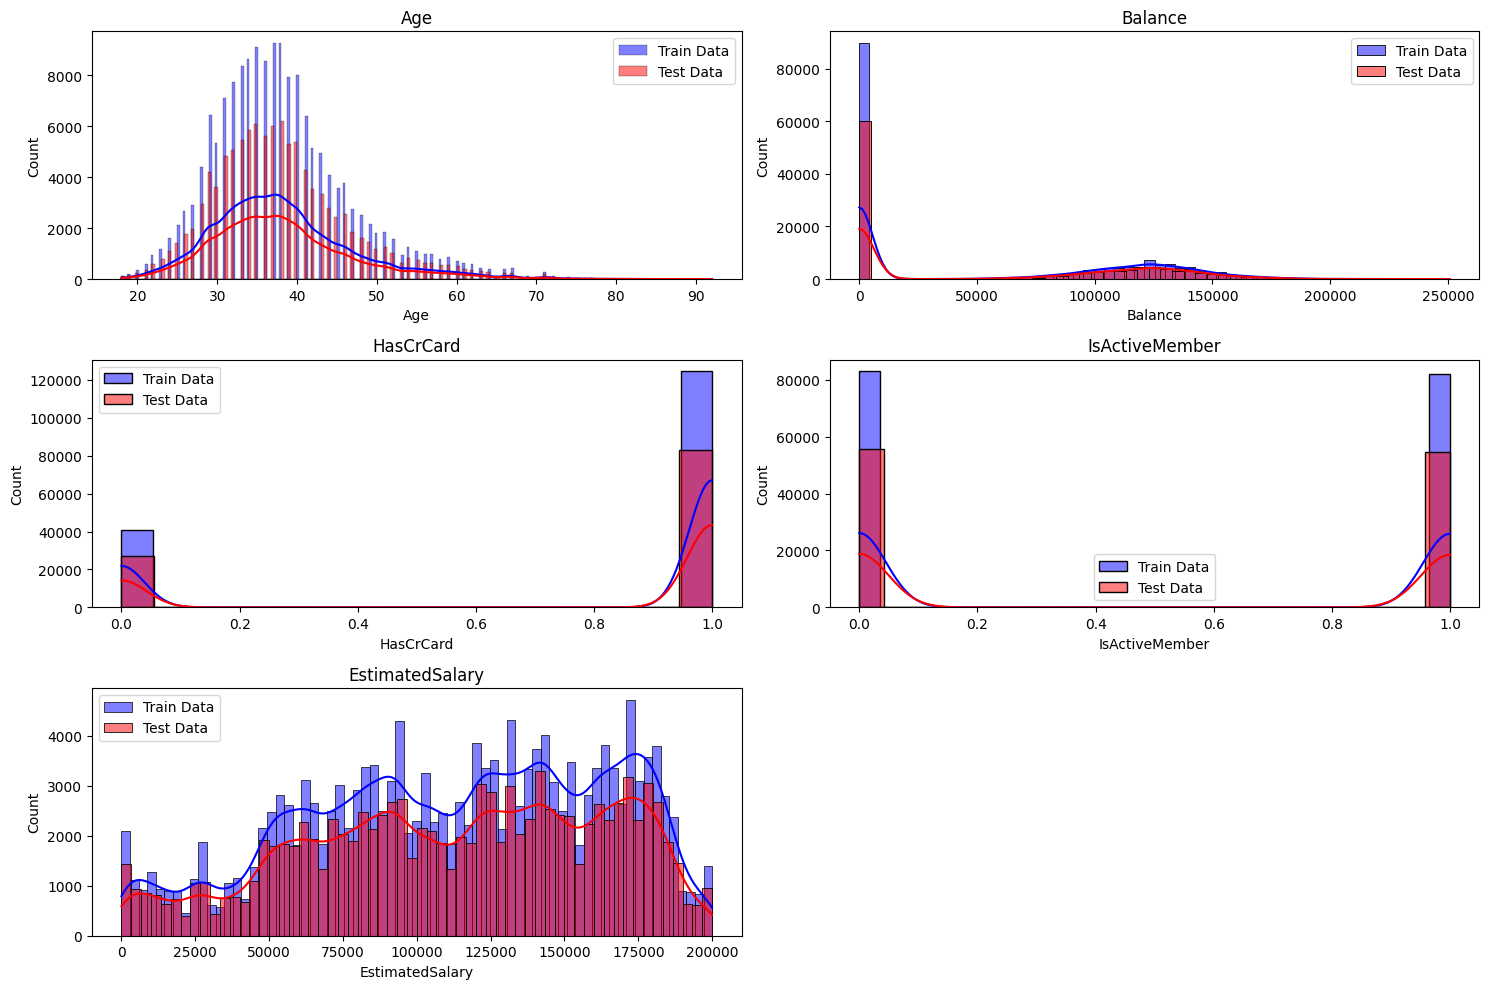

In [ ]:

# 데이터프레임(df)에서 연속형 변수만 선택
continuous_vars = raw_train.drop(columns=['Exited']).select_dtypes(include=['float64']).columns.tolist()

# 플롯을 그릴 subplot의 행과 열의 수 설정
num_rows = (len(continuous_vars) + 1) // 2   # 행 수
#num_cols = (len(continuous_vars) + 1) // 2  # 연속형 변수 수에 따라 열 수 설정

# 그림 크기 조절
plt.figure(figsize=(15, 10))

# 각 연속형 변수에 대해 subplot을 생성하고 히스토그램과 KDE 플롯을 그립니다.
for i, var in enumerate(continuous_vars):
    plt.subplot(num_rows,2 , i+1)
    sns.histplot(raw_train[var], kde=True, color='blue', label='Train Data', alpha=0.5)
    sns.histplot(raw_test[var], kde=True, color='red', label='Test Data', alpha=0.5)
    plt.title(var)
    plt.legend()

# subplot 간의 간격 조절
plt.tight_layout()

# 그래프 표시
plt.show()


<Axes: xlabel='Exited'>

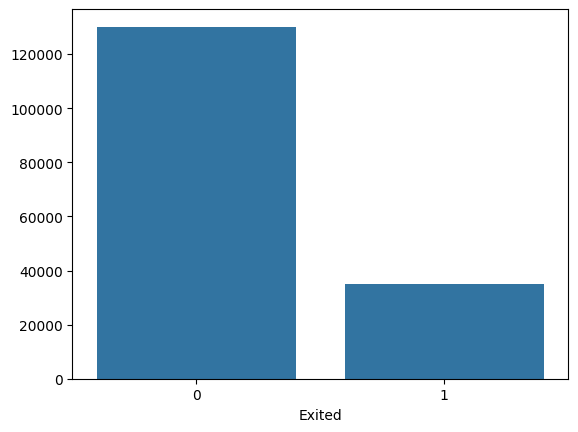

In [ ]:
count = raw_train['Exited'].value_counts()
sns.barplot(x=count.index, y=count.values)

## hue='target'

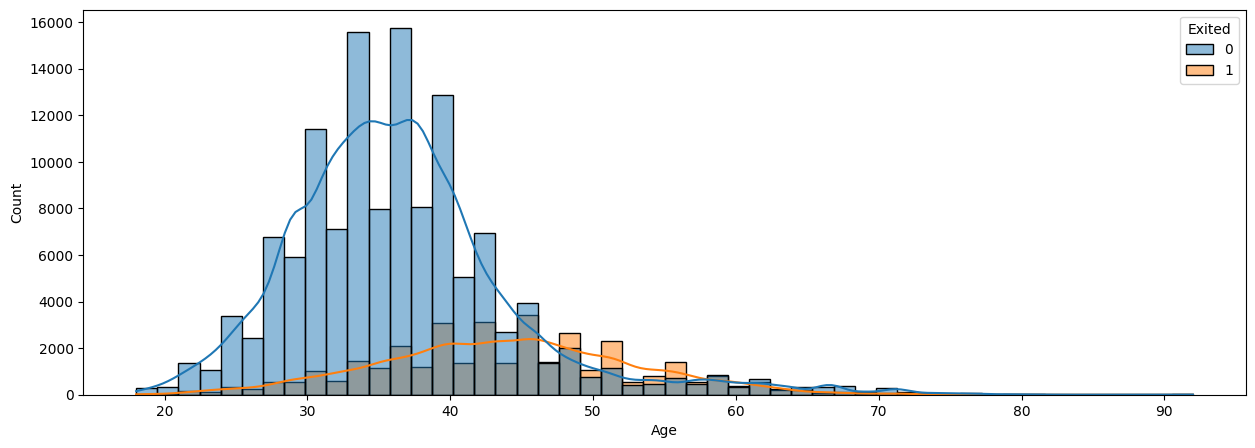

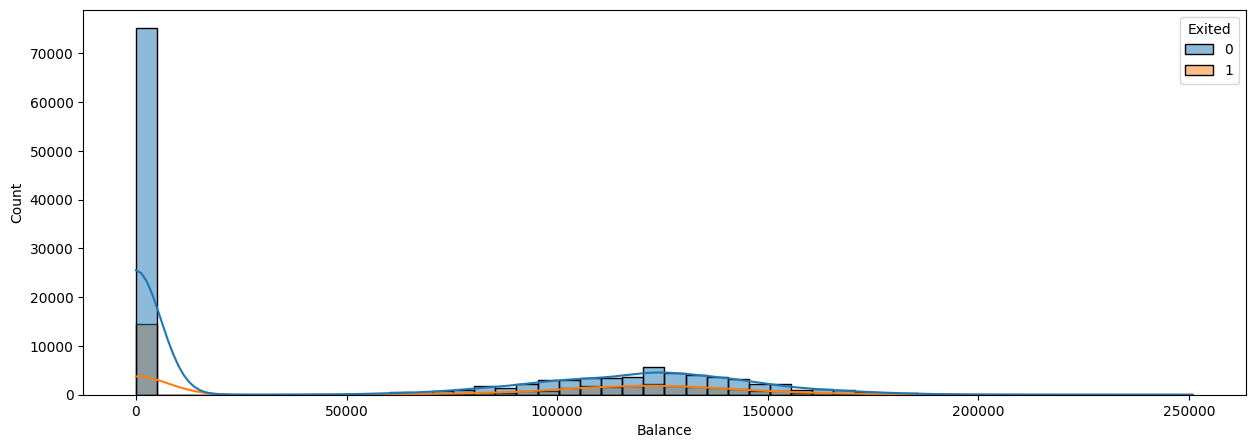

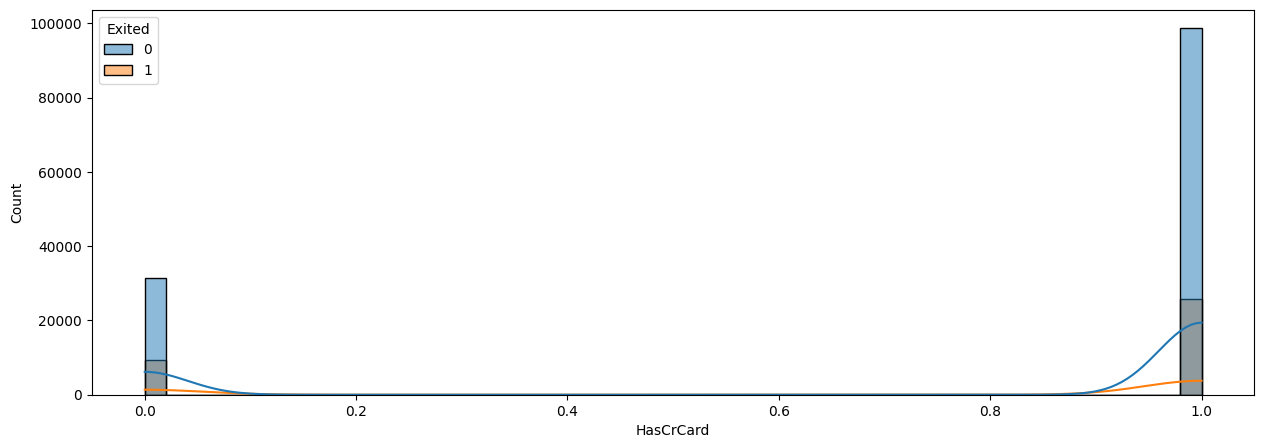

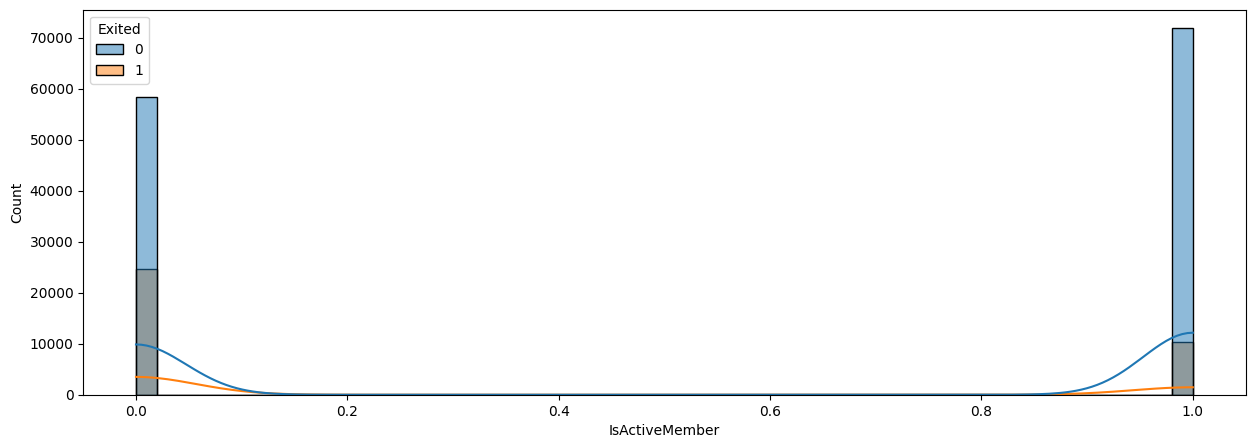

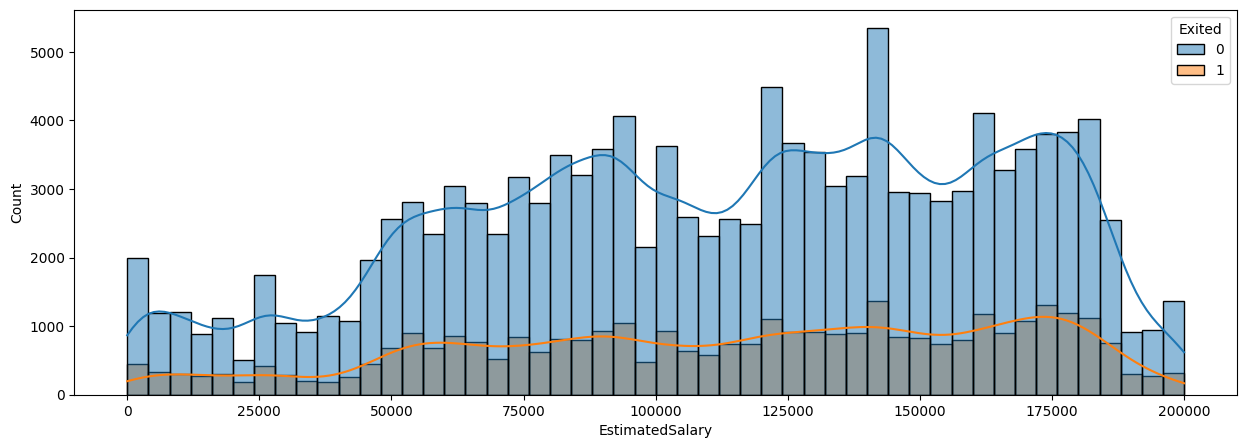

In [ ]:
# 데이터프레임(df)에서 연속형 변수만 선택
continuous_vars = raw_train.select_dtypes(include=['float64']).columns.tolist()

# 플롯을 그릴 subplot의 행과 열의 수 설정
num_rows = (len(continuous_vars) + 1) // 2   # 행 수

for column in continuous_vars:
    plt.figure(figsize=(15, 5))
    fig = sns.histplot(data=raw_train, x=column, hue="Exited", bins=50, kde=True)
    plt.show()

## 이상치확인

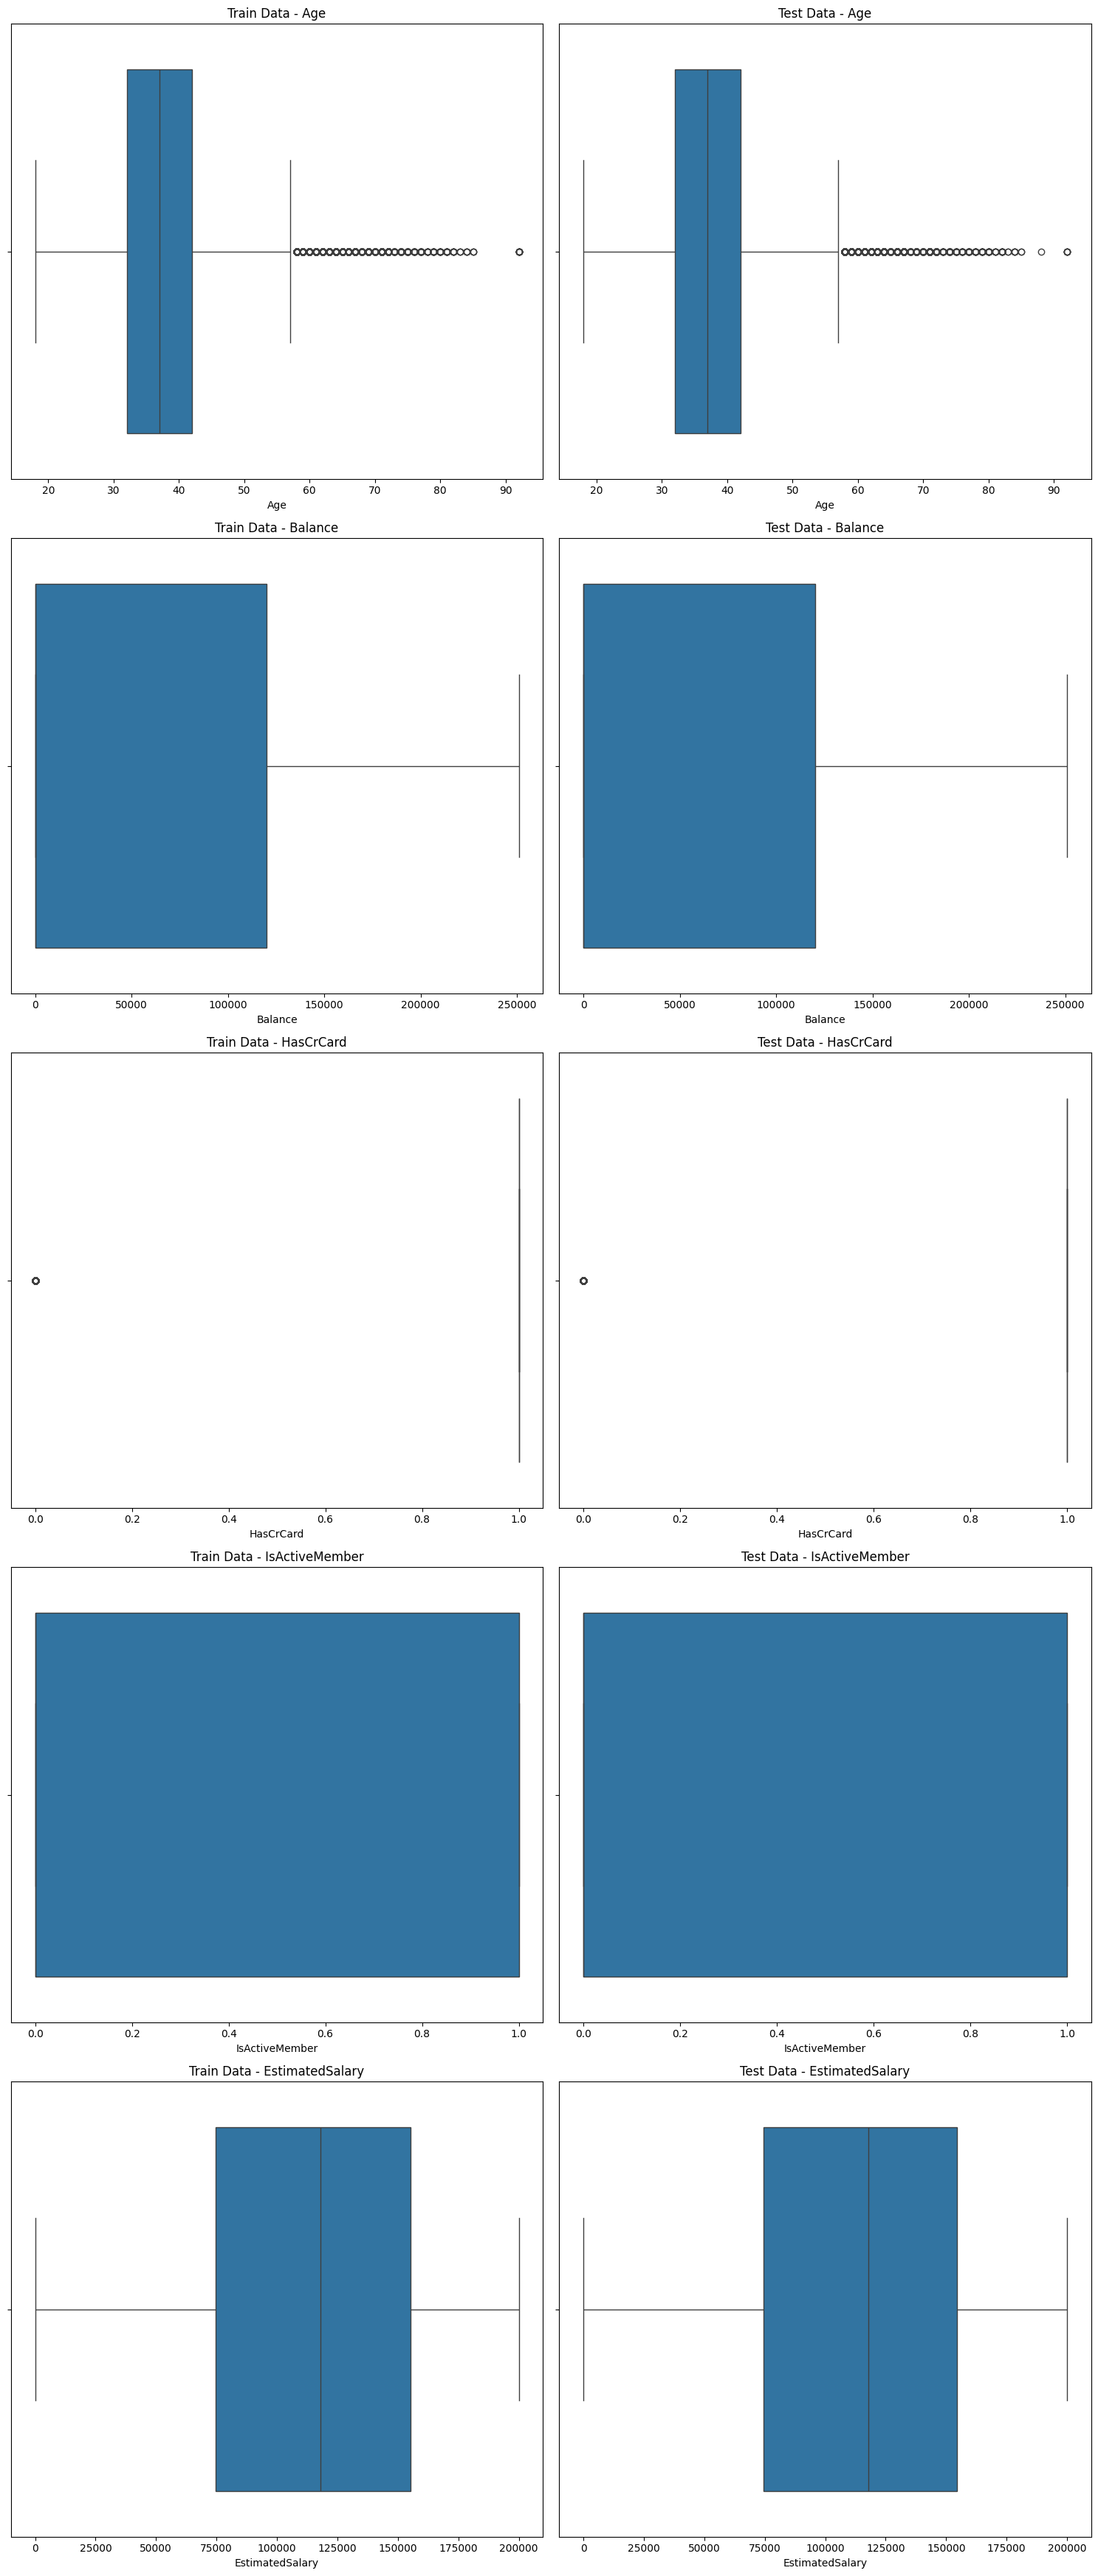

In [ ]:


# train 데이터와 test 데이터에서 float 칼럼만 선택
float_columns = raw_train.select_dtypes(include=['float']).columns.tolist()

# 그림 크기 설정
plt.figure(figsize=(15, 7 * len(float_columns)))

# train 데이터와 test 데이터의 float 칼럼들을 각각의 subplot에 박스플롯으로 표시
for i, col in enumerate(float_columns, start=1):
    plt.subplot(len(float_columns), 2, i*2-1)
    sns.boxplot(x=raw_train[col])
    plt.title(f'Train Data - {col}')

    plt.subplot(len(float_columns), 2, i*2)
    sns.boxplot(x=raw_test[col])
    plt.title(f'Test Data - {col}')

# 그래프 표시
plt.tight_layout()
plt.show()


# 베이스라인
- 0.89750

In [ ]:
#데이터 추가
sub_data=pd.read_csv('Churn_Modelling.csv')
raw_train=pd.read_csv('train.csv')
raw_test=pd.read_csv('test.csv')
sample_submission=pd.read_csv('sample_submission.csv')

In [ ]:
sub_data.drop("RowNumber", axis=1, inplace=True)
sub_data.dropna(inplace=True)
sub_data.drop_duplicates(keep='first', inplace = True)

In [ ]:
raw_train = pd.concat([raw_train, sub_data], axis=0)

In [ ]:
raw_train.drop(['id'], axis=1, inplace=True)
raw_test.drop(['id'], axis=1, inplace=True)

In [ ]:
display(raw_train.info()),display(raw_test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 175030 entries, 0 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerId       175030 non-null  int64  
 1   Surname          175030 non-null  object 
 2   CreditScore      175030 non-null  int64  
 3   Geography        175030 non-null  object 
 4   Gender           175030 non-null  object 
 5   Age              175030 non-null  float64
 6   Tenure           175030 non-null  int64  
 7   Balance          175030 non-null  float64
 8   NumOfProducts    175030 non-null  int64  
 9   HasCrCard        175030 non-null  float64
 10  IsActiveMember   175030 non-null  float64
 11  EstimatedSalary  175030 non-null  float64
 12  Exited           175030 non-null  int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 18.7+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110023 entries, 0 to 110022
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerId       110023 non-null  int64  
 1   Surname          110023 non-null  object 
 2   CreditScore      110023 non-null  int64  
 3   Geography        110023 non-null  object 
 4   Gender           110023 non-null  object 
 5   Age              110023 non-null  float64
 6   Tenure           110023 non-null  int64  
 7   Balance          110023 non-null  float64
 8   NumOfProducts    110023 non-null  int64  
 9   HasCrCard        110023 non-null  float64
 10  IsActiveMember   110023 non-null  float64
 11  EstimatedSalary  110023 non-null  float64
dtypes: float64(5), int64(4), object(3)
memory usage: 10.1+ MB


None

(None, None)

In [ ]:
X=raw_train.drop(columns='Exited')
y=raw_train['Exited']

In [ ]:
feat_cols = X.columns.tolist()

In [ ]:
feat_cols

['CustomerId',
 'Surname',
 'CreditScore',
 'Geography',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary']

In [ ]:
cat_features = np.where(X.dtypes != np.float64)[0]
cat_features

array([0, 1, 2, 3, 4, 6, 8])

In [ ]:
display(X.info()),display(raw_test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 175030 entries, 0 to 10000
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerId       175030 non-null  int64  
 1   Surname          175030 non-null  object 
 2   CreditScore      175030 non-null  int64  
 3   Geography        175030 non-null  object 
 4   Gender           175030 non-null  object 
 5   Age              175030 non-null  float64
 6   Tenure           175030 non-null  int64  
 7   Balance          175030 non-null  float64
 8   NumOfProducts    175030 non-null  int64  
 9   HasCrCard        175030 non-null  float64
 10  IsActiveMember   175030 non-null  float64
 11  EstimatedSalary  175030 non-null  float64
dtypes: float64(5), int64(4), object(3)
memory usage: 17.4+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110023 entries, 0 to 110022
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerId       110023 non-null  int64  
 1   Surname          110023 non-null  object 
 2   CreditScore      110023 non-null  int64  
 3   Geography        110023 non-null  object 
 4   Gender           110023 non-null  object 
 5   Age              110023 non-null  float64
 6   Tenure           110023 non-null  int64  
 7   Balance          110023 non-null  float64
 8   NumOfProducts    110023 non-null  int64  
 9   HasCrCard        110023 non-null  float64
 10  IsActiveMember   110023 non-null  float64
 11  EstimatedSalary  110023 non-null  float64
dtypes: float64(5), int64(4), object(3)
memory usage: 10.1+ MB


None

(None, None)

In [ ]:
clf4=CatBoostClassifier()
clf4.fit(X, y,cat_features=cat_features,verbose=300)
y_pred=clf4.predict_proba(raw_test[feat_cols])[:,1]

Learning rate set to 0.093485
0:	learn: 0.6079820	total: 1.66s	remaining: 27m 38s
300:	learn: 0.3021007	total: 1m 42s	remaining: 3m 58s
600:	learn: 0.2957167	total: 3m 26s	remaining: 2m 17s
900:	learn: 0.2902571	total: 5m 8s	remaining: 33.9s
999:	learn: 0.2884927	total: 5m 42s	remaining: 0us


In [ ]:
sample_submission['Exited'] = y_pred
sample_submission.to_csv('baseline_v1.csv', index=False)

# 예측

## 데이터

In [ ]:
#데이터 추가
sub_data=pd.read_csv('Churn_Modelling.csv')
raw_train=pd.read_csv('train.csv')
raw_test=pd.read_csv('test.csv')
sample_submission=pd.read_csv('sample_submission.csv')

In [ ]:
sub_data.drop("RowNumber", axis=1, inplace=True)
sub_data.dropna(inplace=True)
sub_data.drop_duplicates(keep='first', inplace = True)

In [ ]:
raw_train = pd.concat([raw_train, sub_data], axis=0)

In [ ]:
scale_cols = ['Age','CreditScore', 'Balance','EstimatedSalary']
###
for c in scale_cols:
    min_value = raw_train[c].min()
    max_value = raw_train[c].max()
    raw_train[c+"_scaled"] = (raw_train[c] - min_value) / (max_value - min_value)
    raw_test[c+"_scaled"] = (raw_test[c] - min_value) / (max_value - min_value)

In [ ]:
raw_train['Age']=raw_train['Age'].astype('int')
raw_test['Age']=raw_test['Age'].astype('int')

In [ ]:
raw_train.drop(['id'], axis=1, inplace=True)
raw_test.drop(['id'], axis=1, inplace=True)

In [ ]:
def getFeats(df):

    df['IsSenior'] = df['Age'].apply(lambda x: 1 if x >= 60 else 0)
    df['IsActive_by_CreditCard'] = df['HasCrCard'] * df['IsActiveMember']
    df['Products_Per_Tenure'] =  df['Tenure'] / df['NumOfProducts']
    df['AgeCat'] = np.round(df.Age/20).astype('int').astype('category')
    df['Sur_Geo_Gend_Sal'] = df['Surname']+df['Geography']+df['Gender']+np.round(df.EstimatedSalary).astype('str')

    return df

In [ ]:
df_train = getFeats(raw_train)
df_test = getFeats(raw_test)

In [ ]:
def age_tr(df) :
    df['Age_Category'] = pd.cut(df['Age'], bins=[0, 18, 30, 40, 50, 60, 100], labels=['0', '1', '2', '3', '4', '5'])
    return df

df_train = age_tr(df_train)
df_test = age_tr(df_test)
##original_df = age_tr(original_df)


In [ ]:
def cred_score_tr(df) :
    df['Credit_Score_Range'] = pd.cut(df['CreditScore'], bins=[0, 300, 600, 700, 800, 900], labels=['0-300', '300-600', '600-700', '700-800', '900+'])
    return df
df_train = cred_score_tr(df_train)
df_test = cred_score_tr(df_test)

In [ ]:
def total_pr_tr(df) :
    df['Total_Products_Used'] = df['NumOfProducts'] + df['HasCrCard']
    return df

df_train = cred_score_tr(df_train)
df_test = cred_score_tr(df_test)

In [ ]:
#def tf_idf(train, test, column, n, p):
#    train = train.copy()  # train 데이터프레임 복사
#    test = test.copy()    # test 데이터프레임 복사
#
#    # 데이터프레임의 인덱스를 재설정하여 고유한 값으로 만듭니다.
#    train.reset_index(drop=True, inplace=True)
#    test.reset_index(drop=True, inplace=True)
#
#    vectorizer = TfidfVectorizer(max_features=n)
#    vectors_train = vectorizer.fit_transform(train[column])
#    vectors_test = vectorizer.transform(test[column])
#
#    svd = TruncatedSVD(p)
#    x_pca_train = svd.fit_transform(vectors_train)
#    x_pca_test = svd.transform(vectors_test)
#
#    tfidf_df_train = pd.DataFrame(x_pca_train)
#    tfidf_df_test = pd.DataFrame(x_pca_test)
#
#    cols = [(column+"_tfidf_"+str(f)) for f in tfidf_df_train.columns]
#    tfidf_df_train.columns = cols
#    tfidf_df_test.columns = cols
#
#    train = pd.concat([train, tfidf_df_train], axis="columns")
#    test = pd.concat([test, tfidf_df_test], axis="columns")
#
#    return train, test
#df_train,df_test=tf_idf(df_train,df_test, "Surname",1000,5)

In [ ]:
display(df_train.info()),display(df_test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 175030 entries, 0 to 10000
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   CustomerId              175030 non-null  int64   
 1   Surname                 175030 non-null  object  
 2   CreditScore             175030 non-null  int64   
 3   Geography               175030 non-null  object  
 4   Gender                  175030 non-null  object  
 5   Age                     175030 non-null  int64   
 6   Tenure                  175030 non-null  int64   
 7   Balance                 175030 non-null  float64 
 8   NumOfProducts           175030 non-null  int64   
 9   HasCrCard               175030 non-null  float64 
 10  IsActiveMember          175030 non-null  float64 
 11  EstimatedSalary         175030 non-null  float64 
 12  Exited                  175030 non-null  int64   
 13  Age_scaled              175030 non-null  float64 
 14  CreditScor

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110023 entries, 0 to 110022
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   CustomerId              110023 non-null  int64   
 1   Surname                 110023 non-null  object  
 2   CreditScore             110023 non-null  int64   
 3   Geography               110023 non-null  object  
 4   Gender                  110023 non-null  object  
 5   Age                     110023 non-null  int64   
 6   Tenure                  110023 non-null  int64   
 7   Balance                 110023 non-null  float64 
 8   NumOfProducts           110023 non-null  int64   
 9   HasCrCard               110023 non-null  float64 
 10  IsActiveMember          110023 non-null  float64 
 11  EstimatedSalary         110023 non-null  float64 
 12  Age_scaled              110023 non-null  float64 
 13  CreditScore_scaled      110023 non-null  float64 
 14  Bala

None

(None, None)

In [ ]:
df_train.drop(columns=['IsSenior','HasCrCard'],inplace=True)
df_test.drop(columns=['IsSenior','HasCrCard'],inplace=True)

In [ ]:
display(df_train.info()),display(df_test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 175030 entries, 0 to 10000
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   CustomerId              175030 non-null  int64   
 1   Surname                 175030 non-null  object  
 2   CreditScore             175030 non-null  int64   
 3   Geography               175030 non-null  object  
 4   Gender                  175030 non-null  object  
 5   Age                     175030 non-null  int64   
 6   Tenure                  175030 non-null  int64   
 7   Balance                 175030 non-null  float64 
 8   NumOfProducts           175030 non-null  int64   
 9   IsActiveMember          175030 non-null  float64 
 10  EstimatedSalary         175030 non-null  float64 
 11  Exited                  175030 non-null  int64   
 12  Age_scaled              175030 non-null  float64 
 13  CreditScore_scaled      175030 non-null  float64 
 14  Balance_sc

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110023 entries, 0 to 110022
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   CustomerId              110023 non-null  int64   
 1   Surname                 110023 non-null  object  
 2   CreditScore             110023 non-null  int64   
 3   Geography               110023 non-null  object  
 4   Gender                  110023 non-null  object  
 5   Age                     110023 non-null  int64   
 6   Tenure                  110023 non-null  int64   
 7   Balance                 110023 non-null  float64 
 8   NumOfProducts           110023 non-null  int64   
 9   IsActiveMember          110023 non-null  float64 
 10  EstimatedSalary         110023 non-null  float64 
 11  Age_scaled              110023 non-null  float64 
 12  CreditScore_scaled      110023 non-null  float64 
 13  Balance_scaled          110023 non-null  float64 
 14  Esti

None

(None, None)

In [ ]:
X=df_train.drop(columns='Exited')
y=df_train['Exited']

In [ ]:
feat_cols=X.columns

In [ ]:
feat_cols

Index(['CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age',
       'Tenure', 'Balance', 'NumOfProducts', 'IsActiveMember',
       'EstimatedSalary', 'Age_scaled', 'CreditScore_scaled', 'Balance_scaled',
       'EstimatedSalary_scaled', 'IsActive_by_CreditCard',
       'Products_Per_Tenure', 'AgeCat', 'Sur_Geo_Gend_Sal', 'Age_Category',
       'Credit_Score_Range'],
      dtype='object')

In [ ]:
cat_features = np.where(X.dtypes != np.float64)[0]
cat_features

array([ 0,  1,  2,  3,  4,  5,  6,  8, 17, 18, 19, 20])

## 모델링

In [ ]:
RAND_VAL=42
num_folds=5 ## Number of folds
n_est=3500 ## Number of estimators

In [ ]:

folds = StratifiedKFold(n_splits=num_folds,random_state=RAND_VAL,shuffle=True)
test_preds = np.empty((num_folds, len(df_test)))
auc_vals=[]

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):

    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[valid_idx], y.iloc[valid_idx]

    train_pool = Pool(X_train, y_train,cat_features=cat_features)
    val_pool = Pool(X_val, y_val,cat_features=cat_features)

    clf = CatBoostClassifier(
    eval_metric='AUC',
    learning_rate=0.03,
    iterations=n_est)
    clf.fit(train_pool, eval_set=val_pool,verbose=300)

    y_pred_val = clf.predict_proba(X_val[feat_cols])[:,1]
    auc_val = roc_auc_score(y_val, y_pred_val)
    print("AUC for fold ",n_fold,": ",auc_val)
    auc_vals.append(auc_val)

    y_pred_test = clf.predict_proba(df_test[feat_cols])[:,1]
    test_preds[n_fold, :] = y_pred_test
    print("----------------")

0:	test: 0.8605577	best: 0.8605577 (0)	total: 540ms	remaining: 31m 28s
300:	test: 0.8957642	best: 0.8957642 (300)	total: 2m 27s	remaining: 26m 4s
600:	test: 0.8978263	best: 0.8978263 (600)	total: 5m 8s	remaining: 24m 48s
900:	test: 0.8986162	best: 0.8986166 (898)	total: 7m 38s	remaining: 22m 4s
1200:	test: 0.8990311	best: 0.8990311 (1199)	total: 10m 17s	remaining: 19m 41s
1500:	test: 0.8992868	best: 0.8992899 (1484)	total: 12m 58s	remaining: 17m 16s
1800:	test: 0.8995102	best: 0.8995349 (1773)	total: 15m 48s	remaining: 14m 54s
2100:	test: 0.8997041	best: 0.8997054 (2097)	total: 18m 38s	remaining: 12m 24s
2400:	test: 0.8997814	best: 0.8997858 (2393)	total: 21m 24s	remaining: 9m 48s
2700:	test: 0.8997355	best: 0.8997858 (2393)	total: 24m 5s	remaining: 7m 7s
3000:	test: 0.8997192	best: 0.8997858 (2393)	total: 26m 50s	remaining: 4m 27s
3300:	test: 0.8997684	best: 0.8998019 (3180)	total: 29m 34s	remaining: 1m 46s
3499:	test: 0.8998185	best: 0.8998361 (3465)	total: 31m 16s	remaining: 0us

be

In [ ]:
sample_submission['Exited'] = y_pred_test
sample_submission.to_csv('remove_feat_v1.csv', index=False)

In [ ]:
clf.get_feature_importance()

array([ 4.35956627,  8.0184818 ,  3.21450868,  5.54891082,  4.07136118,
       10.92752238,  1.76360044,  5.46338604, 21.35704044,  8.27062548,
        2.14109677,  5.72729632,  3.13490718,  4.87519231,  1.11746838,
        1.56511358,  1.31233714,  1.32310895,  2.00511047,  2.68676033,
        1.11660501])

# 결과
- private score 0.89815 로 리더보드 254위에 해당함


## 사진첨부
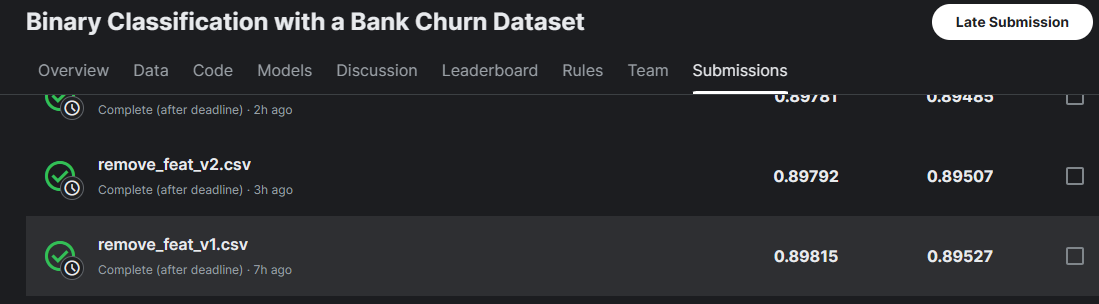

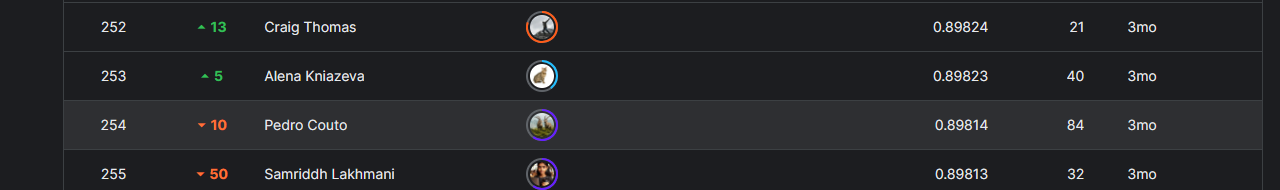

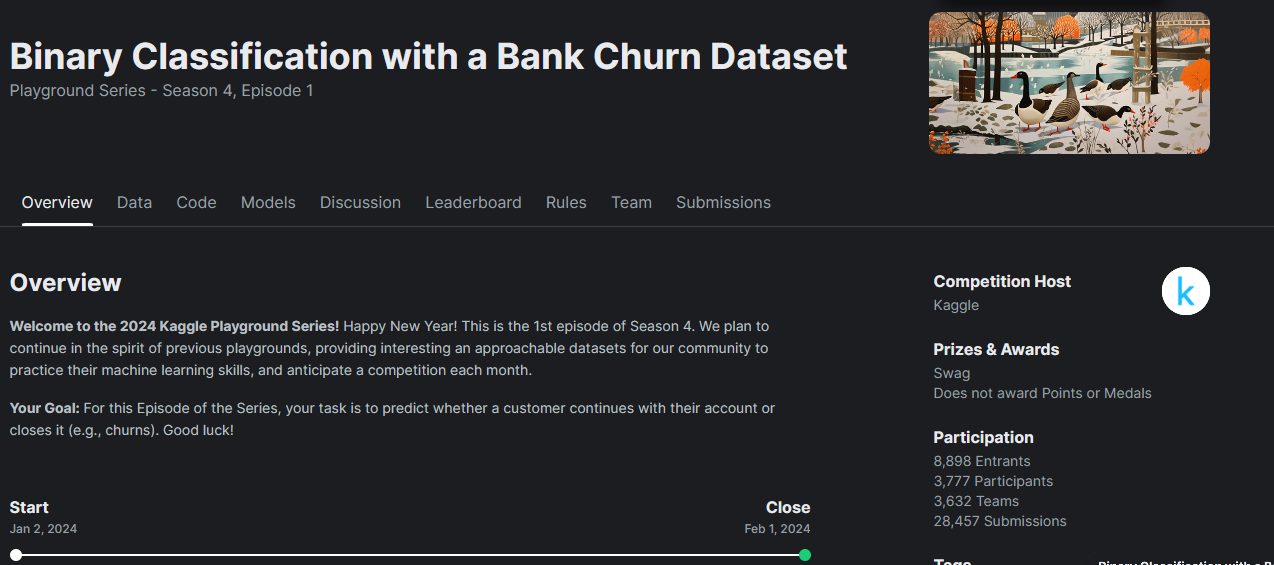